In [1]:
import logging
import numpy as np
import pandas as pd

from src.datasets import load_iris
from src.shadow_learn import ShadowedSetEstimator
from src.utils import create_logfile, log_last_execution, plot_shadowed_set

In [2]:
log = False
create_logfile('grid_search_two_phases_tensorflow',
              'Started Grid Search for TensorFlow Two Phases Models on Iris dataset', log)

## Iris-virginica conservative metric GridSearch

In [4]:
X, y, iris_labels = load_iris(d=2)
X_train, y_train, iris_train_labels = [], [], []
X_test, y_test, iris_test_labels = [], [], []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

logging.info('Splitting in training and test sets with ' + str(sss))

for train_index, test_index in sss.split(X, iris_labels):
    X_train = X[train_index]
    y_train = y[train_index]
    iris_train_labels = iris_labels[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    iris_test_labels = iris_labels[test_index]

pd.Series(iris_train_labels).value_counts(), pd.Series(iris_test_labels).value_counts()

(Iris-virginica     35
 Iris-versicolor    35
 Iris-setosa        35
 dtype: int64,
 Iris-virginica     15
 Iris-setosa        15
 Iris-versicolor    15
 dtype: int64)

In [5]:
logging.info('X_train: ' + str(X_train))
logging.info('y_train: ' + str(y_train))
logging.info('iris_train_labels: ' + str(iris_train_labels))
logging.info('X_test: ' + str(X_test))
logging.info('y_test: ' + str(y_test))
logging.info('iris_test_labels: ' + str(iris_test_labels))

In [6]:
C0_range = np.concatenate((np.logspace(-1, 0, 5), [0.05]))
C1_range = np.concatenate((np.logspace(-1, 0, 5), []))
sigma_range = np.concatenate((np.logspace(-1, 1, 5), [1.4]))
scoring = {'conservative': make_scorer(conservative_score)}
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)  # StratifiedKFold should be default with ClassifierMixin anyway

In [7]:
logging.info('C0_range: ' + str(C0_range))
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [8]:
gs = GridSearchCV(ShadowedSetEstimator(solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

second phase: 100%|██████████| 40/40 [00:01<00:00, 34.42it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 27.02it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.15it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.60it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.19it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.63it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.55it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.28it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 33.33it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.36it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 33.78it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.76it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 34.92it/s]


second phase: 100%|██████████| 40/40 [00:01<00:00, 30.82it/s]


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(solver='tensorflow-two-phases'),
             param_grid={'C0': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ,
       0.05      ]),
                         'C1': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ]),
                         'sigma': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ,
        1.4       ])},
             refit='conservative', return_train_score=True,
             scoring={'conservative': make_scorer(conservative_score)})

In [9]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                          1.99109
std_fit_time                                                         0.0216494
mean_score_time                                                     0.00376561
std_score_time                                                      0.00045975
param_C0                                                              0.562341
param_C1                                                              0.562341
param_sigma                                                                1.4
params                       {'C0': 0.5623413251903491, 'C1': 0.56234132519...
split0_test_conservative                                                     1
split1_test_conservative                                              0.909091
split2_test_conservative                                              0.727273
split3_test_conservative                                              0.818182
split4_test_conservative                            

In [10]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.8888888888888888, 0.7111111111111111)

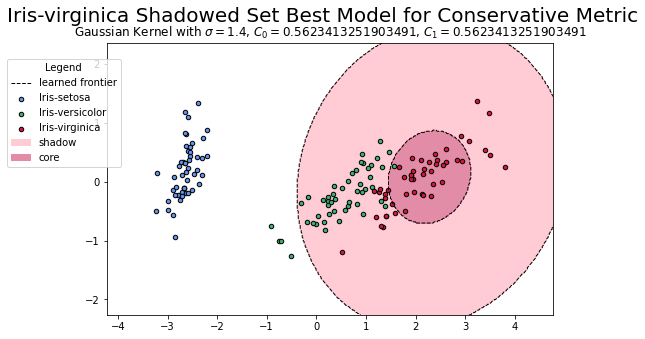

In [11]:
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
label_colors = ['cornflowerblue', 'mediumseagreen', 'crimson']

titles = [r'Gaussian Kernel with $\sigma =' + str(gs.best_params_['sigma']) + '$, $C_0 = '
          + str(gs.best_params_['C0']) + '$, $C_1 = ' + str(gs.best_params_['C1']) + '$']

suptitle = 'Iris-virginica Shadowed Set Best Model for Conservative Metric'
contourf_levels = [-2, -1, 0, 1]
contourf_colors = ['white', 'pink', 'palevioletred', 'red']
contour_levels = [-1, 0]
models = [final_model]
plot_shadowed_set(1, 1, X, iris_labels, labels, label_colors, models, titles, suptitle,
                      contourf_levels, contourf_colors, contour_levels)

## Iris-virginica conservative metric score charts with fixed C0

In [19]:
logging.info('*** Iris-virginica conservative metric score charts with fixed C0 ***')

In [20]:
best_C0 = gs.best_params_['C0']
best_C1 = gs.best_params_['C1']
best_sigma = gs.best_params_['sigma']

In [21]:
logging.info('best_C0: ' + str(best_C0))
logging.info('best_C1: ' + str(best_C1))
logging.info('best_sigma: ' + str(best_sigma))

In [22]:
C1_range = np.sort(np.concatenate((np.linspace(best_C1 / 2, best_C1 * 2, 10), [best_C1])))
sigma_range = np.sort(np.concatenate((np.linspace(best_sigma / 2, best_sigma * 2, 10), [best_sigma])))
scoring = {'conservative': make_scorer(conservative_score)}
param_grid = {'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [23]:
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [24]:
# Fisso C0 perché ininfluente ai fini della metrica Conservative (gli incerti sono classificati come -1)
gs = GridSearchCV(ShadowedSetEstimator(C0=best_C0, solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(),
             param_grid={'C1': array([0.15811388, 0.21081851, 0.26352314, 0.31622777, 0.31622777,
       0.36893239, 0.42163702, 0.47434165, 0.52704628, 0.5797509 ,
       0.63245553]),
                         'sigma': array([0.7       , 0.93333333, 1.16666667, 1.4       , 1.4       ,
       1.63333333, 1.86666667, 2.1       , 2.33333333, 2.56666667,
       2.8       ])},
             refit='conservative', return_train_score=True,
             scoring={'conservative': make_scorer(conservative_score)})

In [25]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                0.0620127
std_fit_time                                                 0.0019342
mean_score_time                                             0.00351899
std_score_time                                             0.000476936
param_C1                                                      0.316228
param_sigma                                                        1.4
params                       {'C1': 0.31622776601683794, 'sigma': 1.4}
split0_test_conservative                                             1
split1_test_conservative                                             1
split2_test_conservative                                      0.818182
split3_test_conservative                                             1
split4_test_conservative                                      0.909091
split5_test_conservative                                             1
split6_test_conservative                                             1
split7

In [31]:
pd.DataFrame(gs.cv_results_)[['param_C1', 'param_sigma', 'mean_test_conservative']]

param_C1 param_sigma  mean_test_conservative
0    0.158114         0.7                0.865455
1    0.158114    0.933333                0.895455
2    0.158114     1.16667                0.885455
3    0.158114         1.4                0.903636
4    0.158114         1.4                0.903636
..        ...         ...                     ...
116  0.632456     1.86667                0.922727
117  0.632456         2.1                0.903636
118  0.632456     2.33333                0.893636
119  0.632456     2.56667                0.883636
120  0.632456         2.8                0.874545

[121 rows x 3 columns]

In [26]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.9333333333333333)

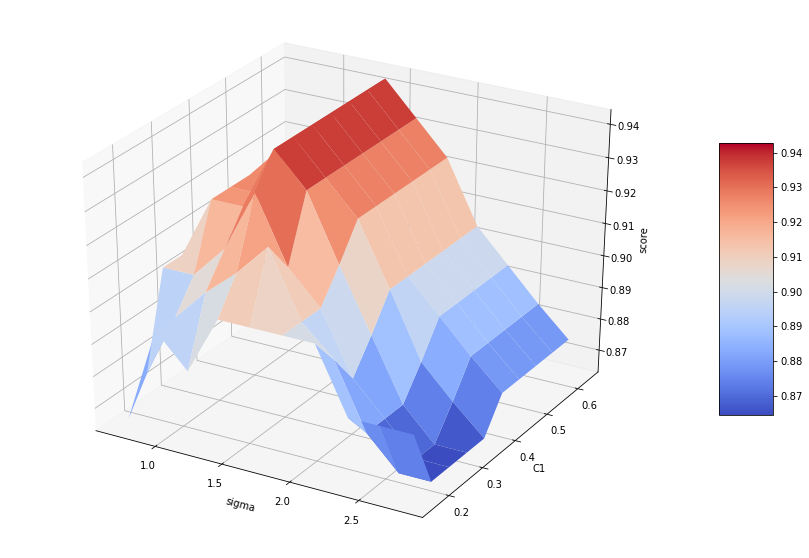

In [27]:
plot_score_surface(sigma_range, C1_range, gs, 'conservative', 'sigma', 'C1')

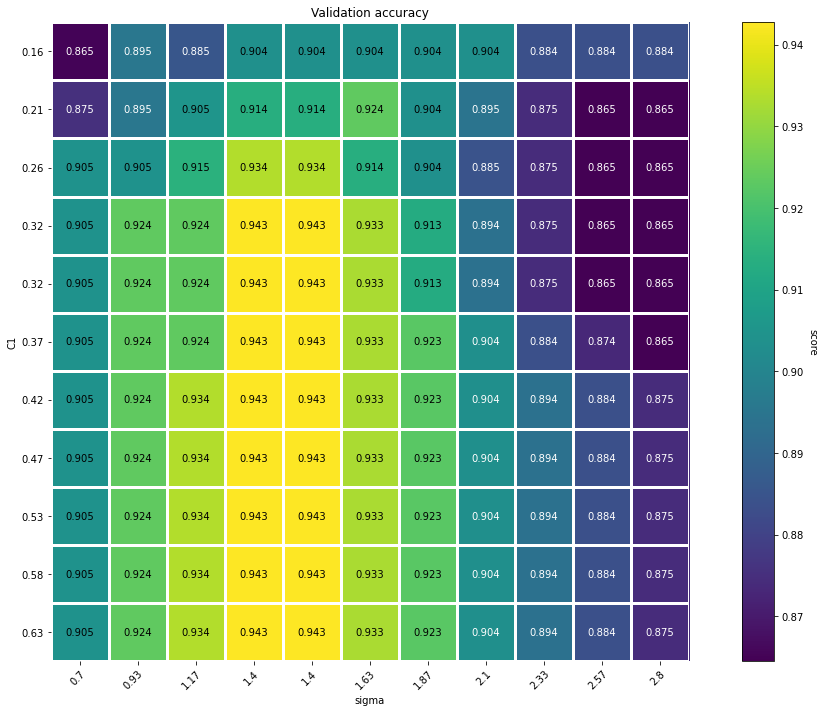

In [32]:
plot_score_heatmap(C1_range, sigma_range, gs, 'conservative', 'sigma', 'C1')

## Iris-virginica conservative metric score charts with fixed C1

In [33]:
logging.info('*** Iris-virginica conservative metric score charts with fixed C1 ***')

In [34]:
C0_range = np.sort(np.concatenate((np.linspace(best_C0 / 2, best_C0 * 2, 10), [best_C0])))
sigma_range = np.sort(np.concatenate((np.linspace(best_sigma / 2, best_sigma * 2, 10), [best_sigma])))
scoring = {'conservative': make_scorer(conservative_score)}
param_grid = {'C0': C0_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [35]:
logging.info('C0_range: ' + str(C0_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [36]:
gs = GridSearchCV(ShadowedSetEstimator(C1=best_C1, solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(C1=0.31622776601683794),
             param_grid={'C0': array([0.05      , 0.06666667, 0.08333333, 0.1       , 0.1       ,
       0.11666667, 0.13333333, 0.15      , 0.16666667, 0.18333333,
       0.2       ]),
                         'sigma': array([0.7       , 0.93333333, 1.16666667, 1.4       , 1.4       ,
       1.63333333, 1.86666667, 2.1       , 2.33333333, 2.56666667,
       2.8       ])},
             refit='conservative', return_train_score=True,
             scoring={'conservative': make_scorer(conservative_score)})

In [37]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                  0.061351
std_fit_time                                 0.00246886
mean_score_time                              0.00341635
std_score_time                              0.000483705
param_C0                                           0.05
param_sigma                                         1.4
params                       {'C0': 0.05, 'sigma': 1.4}
split0_test_conservative                              1
split1_test_conservative                              1
split2_test_conservative                       0.818182
split3_test_conservative                              1
split4_test_conservative                       0.909091
split5_test_conservative                              1
split6_test_conservative                              1
split7_test_conservative                              1
split8_test_conservative                            0.9
split9_test_conservative                            0.8
mean_test_conservative                         0

In [38]:
pd.DataFrame(gs.cv_results_)[['param_C0', 'param_sigma', 'mean_test_conservative']]

param_C0 param_sigma  mean_test_conservative
0       0.05         0.7                0.904545
1       0.05    0.933333                0.923636
2       0.05     1.16667                0.923636
3       0.05         1.4                0.942727
4       0.05         1.4                0.942727
..       ...         ...                     ...
116      0.2     1.86667                0.912727
117      0.2         2.1                0.893636
118      0.2     2.33333                0.874545
119      0.2     2.56667                0.864545
120      0.2         2.8                0.864545

[121 rows x 3 columns]

In [39]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.7555555555555555)

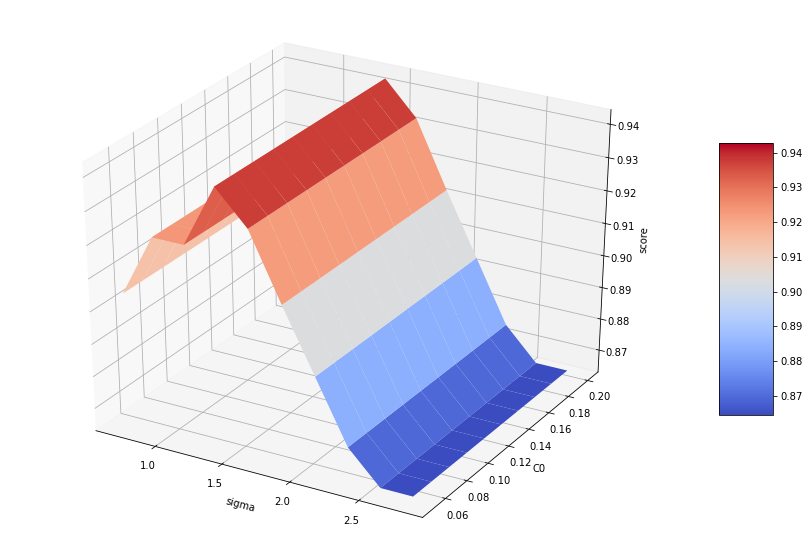

In [40]:
plot_score_surface(sigma_range, C0_range, gs, 'conservative', 'sigma', 'C0')

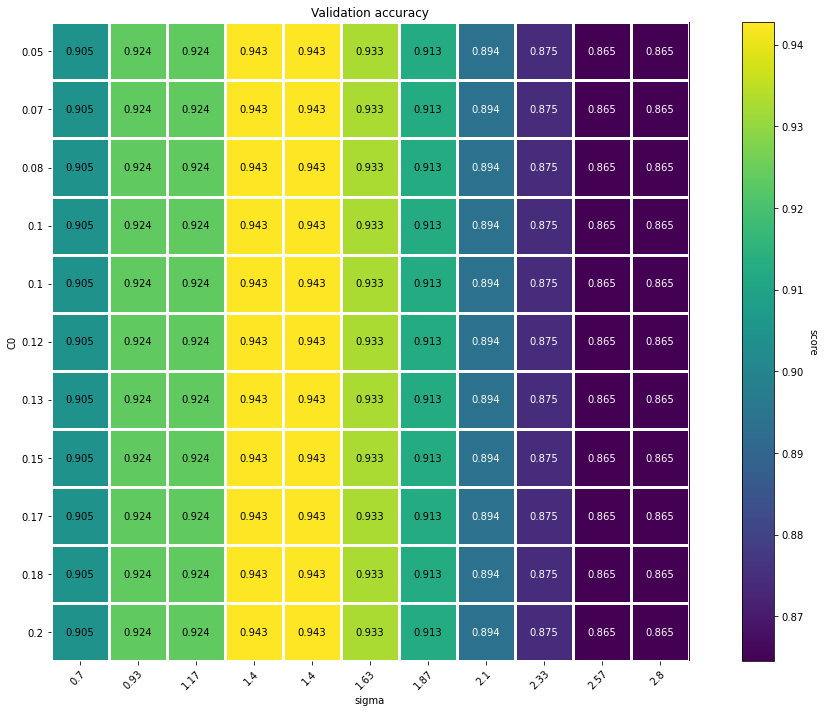

In [41]:
plot_score_heatmap(C0_range, sigma_range, gs, 'conservative', 'sigma', 'C0')

## Iris-virginica non-conservative metric GridSearch

In [42]:
logging.info('*** Iris-virginica non-conservative metric GridSearch ***')

In [43]:
C0_range = np.concatenate((np.logspace(-1, 0, 5), []))
C1_range = np.concatenate((np.logspace(-1, 0, 5), []))
sigma_range = np.concatenate((np.logspace(-1, 1, 5), [1.4]))
scoring = {'non-conservative': make_scorer(non_conservative_score)}
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)  # StratifiedKFold should be default with ClassifierMixin

In [44]:
logging.info('C0_range: ' + str(C0_range))
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [45]:
gs = GridSearchCV(ShadowedSetEstimator(solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='non-conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(),
             param_grid={'C0': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ,
       0.05      ]),
                         'C1': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ]),
                         'sigma': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ,
        1.4       ])},
             refit='non-conservative', return_train_score=True,
             scoring={'non-conservative': make_scorer(non_conservative_score)})

In [46]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                             0.061893
std_fit_time                                                            0.00101951
mean_score_time                                                         0.00380621
std_score_time                                                           0.0002933
param_C0                                                                         1
param_C1                                                                  0.316228
param_sigma                                                                    1.4
params                           {'C0': 1.0, 'C1': 0.31622776601683794, 'sigma'...
split0_test_non-conservative                                                     1
split1_test_non-conservative                                                     1
split2_test_non-conservative                                              0.818182
split3_test_non-conservative                                                     1
spli

In [47]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.9333333333333333)

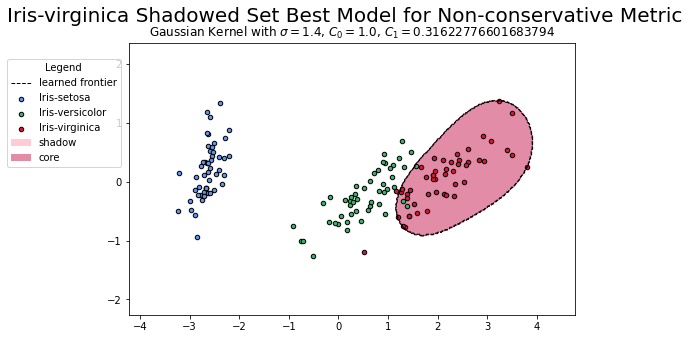

In [48]:
titles = [r'Gaussian Kernel with $\sigma =' + str(gs.best_params_['sigma']) + '$, $C_0 = '
          + str(gs.best_params_['C0']) + '$, $C_1 = ' + str(gs.best_params_['C1']) + '$']

suptitle = 'Iris-virginica Shadowed Set Best Model for Non-conservative Metric'
contourf_levels = [-2, -1, 0, 1]
contourf_colors = ['white', 'pink', 'palevioletred', 'red']
contour_levels = [-1, 0]
models = [final_model]
plot_shadowed_set(1, 1, X, iris_labels, labels, label_colors, models, titles, suptitle,
                      contourf_levels, contourf_colors, contour_levels)

## Iris-virginica non-conservative metric score charts with fixed C1

In [49]:
logging.info('*** Iris-virginica non-conservative metric score charts with fixed C1 ***')

In [50]:
best_C0 = gs.best_params_['C0']
best_C1 = gs.best_params_['C1']
best_sigma = gs.best_params_['sigma']

In [51]:
logging.info('best_C0: ' + str(best_C0))
logging.info('best_C1: ' + str(best_C1))
logging.info('best_sigma: ' + str(best_sigma))

In [52]:
C0_range = np.sort(np.concatenate((np.linspace(best_C0 / 2, best_C0 * 2, 10), [best_C0])))
sigma_range = np.sort(np.concatenate((np.linspace(best_sigma / 2, best_sigma * 2, 10), [best_sigma])))
scoring = {'non-conservative': make_scorer(non_conservative_score)}
param_grid = {'C0': C0_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [53]:
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [54]:
# Fisso C1 perché ininfluente ai fini della metrica Non-conservative (gli incerti sono classificati come 1)
gs = GridSearchCV(ShadowedSetEstimator(C1=best_C1, solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='non-conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(C1=0.31622776601683794),
             param_grid={'C0': array([0.5       , 0.66666667, 0.83333333, 1.        , 1.        ,
       1.16666667, 1.33333333, 1.5       , 1.66666667, 1.83333333,
       2.        ]),
                         'sigma': array([0.7       , 0.93333333, 1.16666667, 1.4       , 1.4       ,
       1.63333333, 1.86666667, 2.1       , 2.33333333, 2.56666667,
       2.8       ])},
             refit='non-conservative', return_train_score=True,
             scoring={'non-conservative': make_scorer(non_conservative_score)})

In [55]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                    0.0614862
std_fit_time                                    0.00166376
mean_score_time                                 0.00322371
std_score_time                                  0.00044561
param_C0                                                 1
param_sigma                                            1.4
params                           {'C0': 1.0, 'sigma': 1.4}
split0_test_non-conservative                             1
split1_test_non-conservative                             1
split2_test_non-conservative                      0.818182
split3_test_non-conservative                             1
split4_test_non-conservative                      0.909091
split5_test_non-conservative                             1
split6_test_non-conservative                             1
split7_test_non-conservative                             1
split8_test_non-conservative                           0.9
split9_test_non-conservative                           0

In [60]:
pd.DataFrame(gs.cv_results_)[['param_C0', 'param_sigma', 'mean_test_non-conservative']]

param_C0 param_sigma  mean_test_non-conservative
0        0.5         0.7                    0.904545
1        0.5    0.933333                    0.913636
2        0.5     1.16667                    0.923636
3        0.5         1.4                    0.932727
4        0.5         1.4                    0.932727
..       ...         ...                         ...
116        2     1.86667                    0.912727
117        2         2.1                    0.893636
118        2     2.33333                    0.874545
119        2     2.56667                    0.864545
120        2         2.8                    0.864545

[121 rows x 3 columns]

In [61]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.9333333333333333)

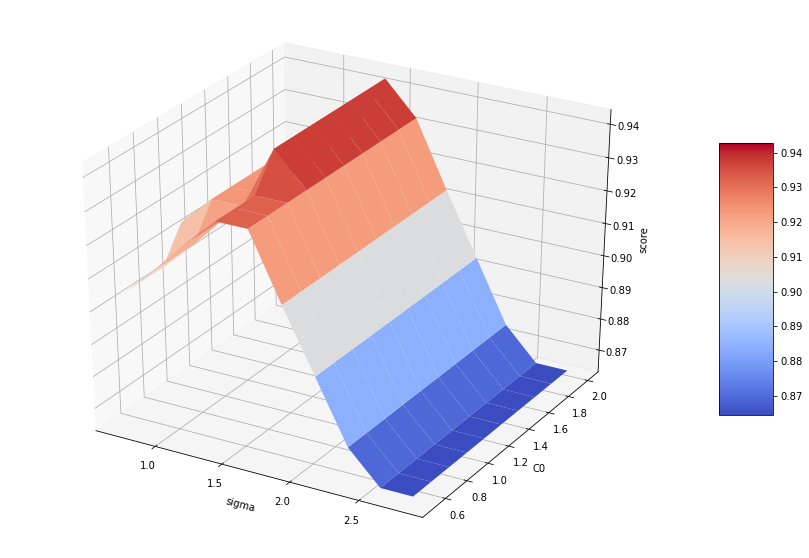

In [62]:
plot_score_surface(sigma_range, C0_range, gs, 'non-conservative', 'sigma', 'C0')

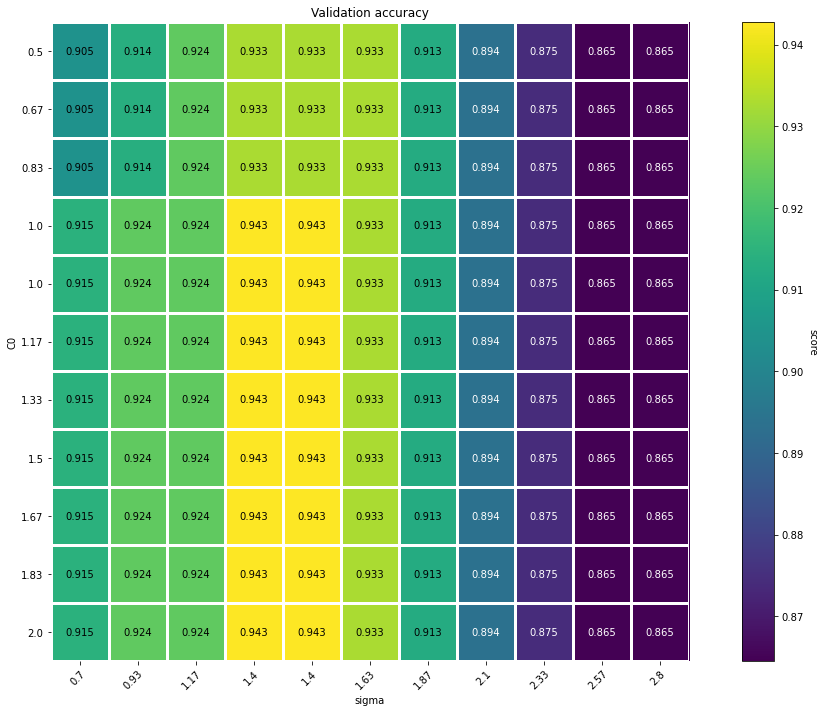

In [63]:
plot_score_heatmap(C0_range, sigma_range, gs, 'non-conservative', 'sigma', 'C0')

## Iris-virginica non-conservative metric score charts with fixed C0

In [64]:
logging.info('*** Iris-virginica non-conservative metric score charts with fixed C0 ***')

In [70]:
C1_range = np.sort(np.concatenate((np.linspace(best_C1 / 2, best_C1 * 2, 10), [best_C1])))
sigma_range = np.sort(np.concatenate((np.linspace(best_sigma / 2, best_sigma * 2, 10), [best_sigma])))
scoring = {'non-conservative': make_scorer(non_conservative_score)}
param_grid = {'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [71]:
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [72]:
gs = GridSearchCV(ShadowedSetEstimator(C0=best_C0, solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='non-conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(C0=1.0),
             param_grid={'C1': array([0.15811388, 0.21081851, 0.26352314, 0.31622777, 0.31622777,
       0.36893239, 0.42163702, 0.47434165, 0.52704628, 0.5797509 ,
       0.63245553]),
                         'sigma': array([0.7       , 0.93333333, 1.16666667, 1.4       , 1.4       ,
       1.63333333, 1.86666667, 2.1       , 2.33333333, 2.56666667,
       2.8       ])},
             refit='non-conservative', return_train_score=True,
             scoring={'non-conservative': make_scorer(non_conservative_score)})

In [73]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                    0.0622216
std_fit_time                                                   0.000957196
mean_score_time                                                  0.0036113
std_score_time                                                 0.000447211
param_C1                                                          0.316228
param_sigma                                                            1.4
params                           {'C1': 0.31622776601683794, 'sigma': 1.4}
split0_test_non-conservative                                             1
split1_test_non-conservative                                             1
split2_test_non-conservative                                      0.818182
split3_test_non-conservative                                             1
split4_test_non-conservative                                      0.909091
split5_test_non-conservative                                             1
split6_test_non-conservat

In [74]:
pd.DataFrame(gs.cv_results_)[['param_C1', 'param_sigma', 'mean_test_non-conservative']]

param_C1 param_sigma  mean_test_non-conservative
0    0.158114         0.7                    0.875455
1    0.158114    0.933333                    0.895455
2    0.158114     1.16667                    0.895455
3    0.158114         1.4                    0.913636
4    0.158114         1.4                    0.913636
..        ...         ...                         ...
116  0.632456     1.86667                    0.922727
117  0.632456         2.1                    0.903636
118  0.632456     2.33333                    0.893636
119  0.632456     2.56667                    0.883636
120  0.632456         2.8                    0.874545

[121 rows x 3 columns]

In [75]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.9333333333333333)

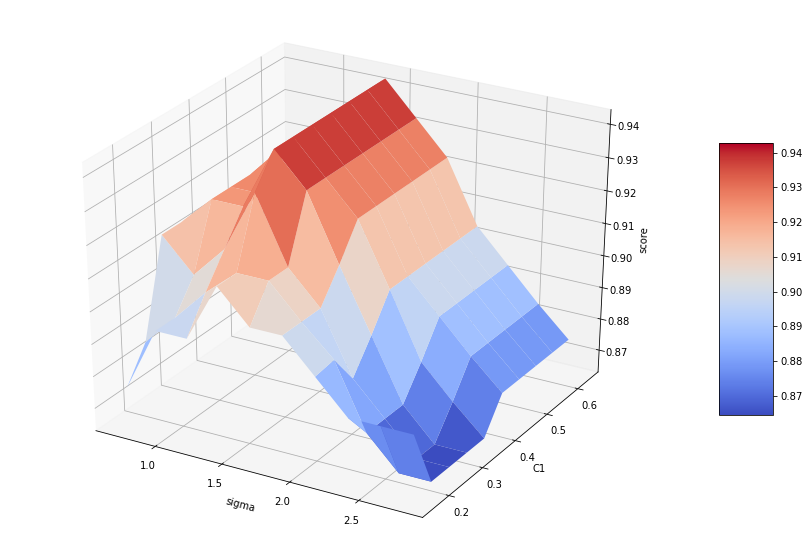

In [76]:
plot_score_surface(sigma_range, C1_range, gs, 'non-conservative', 'sigma', 'C1')

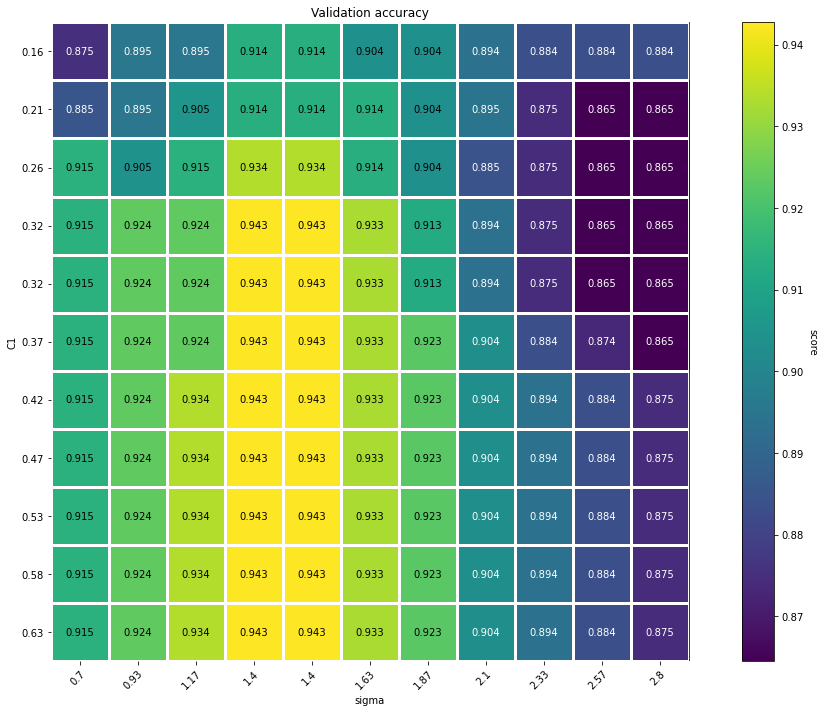

In [78]:
plot_score_heatmap(C1_range, sigma_range,  gs, 'non-conservative', 'sigma', 'C1')

## Iris-versicolor conservative metric GridSearch

In [79]:
logging.info('*** Iris-versicolor conservative metric GridSearch ***')

In [80]:
X, y, iris_labels = load_iris(d=2, target='Iris-versicolor')
X_train, y_train, iris_train_labels = [], [], []
X_test, y_test, iris_test_labels = [], [], []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

logging.info('Splitting in training and test sets with ' + str(sss))

for train_index, test_index in sss.split(X, iris_labels):
    X_train = X[train_index]
    y_train = y[train_index]
    iris_train_labels = iris_labels[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    iris_test_labels = iris_labels[test_index]

pd.Series(iris_train_labels).value_counts(), pd.Series(iris_test_labels).value_counts()

(Iris-setosa        35
 Iris-versicolor    35
 Iris-virginica     35
 dtype: int64,
 Iris-setosa        15
 Iris-versicolor    15
 Iris-virginica     15
 dtype: int64)

In [81]:
logging.info('X_train: ' + str(X_train))
logging.info('y_train: ' + str(y_train))
logging.info('iris_train_labels: ' + str(iris_train_labels))
logging.info('X_test: ' + str(X_test))
logging.info('y_test: ' + str(y_test))
logging.info('iris_test_labels: ' + str(iris_test_labels))

In [116]:
C0_range = np.concatenate((np.logspace(-1, 0, 5), []))
C1_range = np.concatenate((np.logspace(-1, 0, 5), [0.468]))
sigma_range = np.concatenate((np.logspace(-1, 1, 5), [1.36]))
scoring = {'conservative': make_scorer(conservative_score)}
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [117]:
logging.info('C0_range: ' + str(C0_range))
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [118]:
gs = GridSearchCV(ShadowedSetEstimator(solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(),
             param_grid={'C0': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ]),
                         'C1': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ,
       0.421     ]),
                         'sigma': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ,
        1.36      ])},
             refit='conservative', return_train_score=True,
             scoring={'conservative': make_scorer(conservative_score)})

In [119]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                        0.0615927
std_fit_time                                                        0.00152268
mean_score_time                                                     0.00391026
std_score_time                                                     1.97841e-05
param_C0                                                                   0.1
param_C1                                                              0.562341
param_sigma                                                               1.36
params                       {'C0': 0.1, 'C1': 0.5623413251903491, 'sigma':...
split0_test_conservative                                              0.909091
split1_test_conservative                                              0.909091
split2_test_conservative                                              0.909091
split3_test_conservative                                              0.909091
split4_test_conservative                            

In [120]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.8888888888888888)

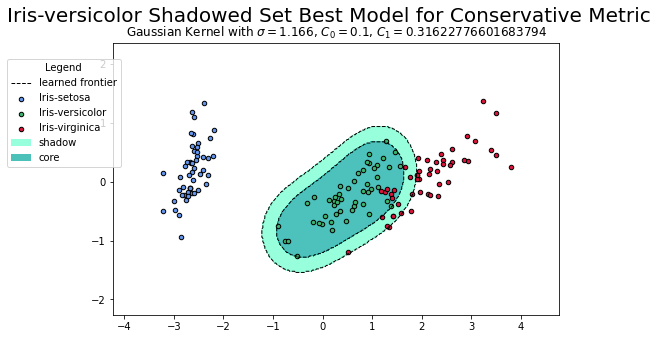

In [106]:
titles = [r'Gaussian Kernel with $\sigma =' + str(gs.best_params_['sigma']) + '$, $C_0 = '
          + str(gs.best_params_['C0']) + '$, $C_1 = ' + str(gs.best_params_['C1']) + '$']

suptitle = 'Iris-versicolor Shadowed Set Best Model for Conservative Metric'
contourf_levels = [-2, -1, 0, 1]
contourf_colors = ['white', 'aquamarine', 'lightseagreen', 'red']
contour_levels = [-1, 0]
models = [final_model]
plot_shadowed_set(1, 1, X, iris_labels, labels, label_colors, models, titles, suptitle,
                      contourf_levels, contourf_colors, contour_levels)

## Iris-versicolor conservative metric score charts with fixed C0

In [121]:
logging.info('*** Iris-versicolor conservative metric score charts with fixed C0 ***')

In [122]:
best_C0 = gs.best_params_['C0']
best_C1 = gs.best_params_['C1']
best_sigma = gs.best_params_['sigma']

In [123]:
logging.info('best_C0: ' + str(best_C0))
logging.info('best_C1: ' + str(best_C1))
logging.info('best_sigma: ' + str(best_sigma))

In [124]:
C1_range = np.sort(np.concatenate((np.linspace(best_C1 / 2, best_C1 * 2, 10), [best_C1])))
sigma_range = np.sort(np.concatenate((np.linspace(best_sigma / 2, best_sigma * 2, 10), [best_sigma])))
scoring = {'conservative': make_scorer(conservative_score)}
param_grid = {'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [125]:
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [126]:
# Fisso C0 perché ininfluente ai fini della metrica Conservative (gli incerti sono classificati come -1)
gs = GridSearchCV(ShadowedSetEstimator(C0=best_C0, solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(),
             param_grid={'C1': array([0.28117066, 0.37489422, 0.46861777, 0.56234133, 0.56234133,
       0.65606488, 0.74978843, 0.84351199, 0.93723554, 1.0309591 ,
       1.12468265]),
                         'sigma': array([0.68      , 0.90666667, 1.13333333, 1.36      , 1.36      ,
       1.58666667, 1.81333333, 2.04      , 2.26666667, 2.49333333,
       2.72      ])},
             refit='conservative', return_train_score=True,
             scoring={'conservative': make_scorer(conservative_score)})

In [127]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                 0.0629023
std_fit_time                                                 0.00189914
mean_score_time                                              0.00371132
std_score_time                                              0.000586679
param_C1                                                       0.468618
param_sigma                                                        1.36
params                       {'C1': 0.46861777099195756, 'sigma': 1.36}
split0_test_conservative                                       0.909091
split1_test_conservative                                       0.909091
split2_test_conservative                                       0.909091
split3_test_conservative                                       0.909091
split4_test_conservative                                              1
split5_test_conservative                                            0.9
split6_test_conservative                                        

In [128]:
pd.DataFrame(gs.cv_results_)[['param_C1', 'param_sigma', 'mean_test_conservative']]

param_C1 param_sigma  mean_test_conservative
0    0.281171        0.68                0.906364
1    0.281171    0.906667                0.915455
2    0.281171     1.13333                0.925455
3    0.281171        1.36                0.925455
4    0.281171        1.36                0.925455
..        ...         ...                     ...
116   1.12468     1.81333                0.924545
117   1.12468        2.04                0.906364
118   1.12468     2.26667                0.896364
119   1.12468     2.49333                0.896364
120   1.12468        2.72                0.886364

[121 rows x 3 columns]

In [129]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.8888888888888888)

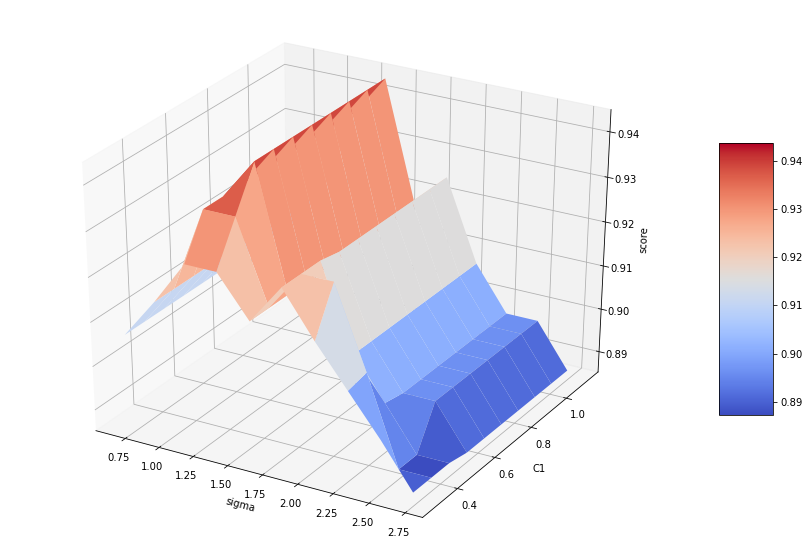

In [130]:
plot_score_surface(sigma_range, C1_range, gs, 'conservative', 'sigma', 'C1')

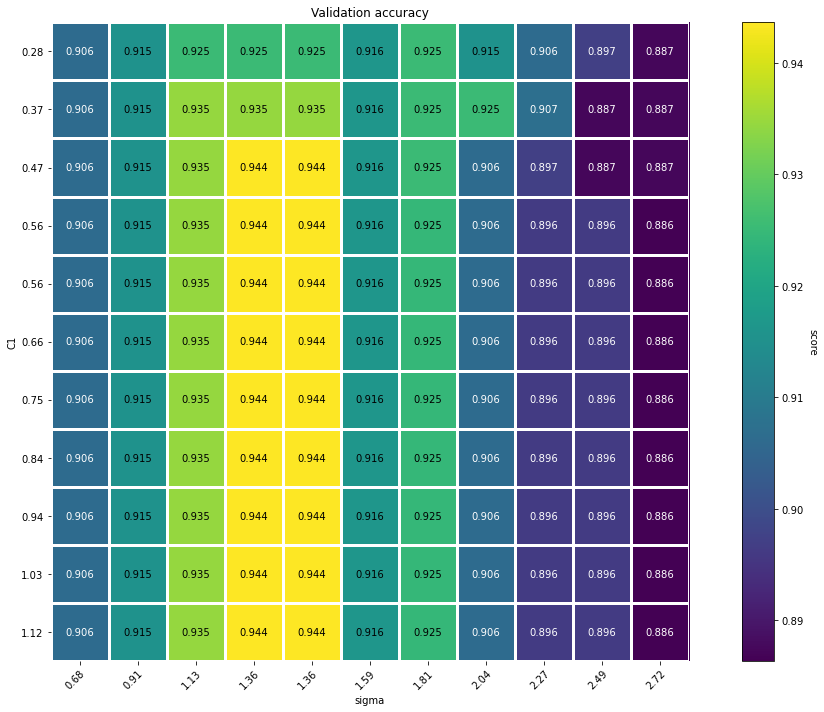

In [131]:
plot_score_heatmap(C1_range, sigma_range, gs, 'conservative', 'sigma', 'C1')

## Iris-versicolor conservative metric score charts with fixed C1

In [132]:
logging.info('*** Iris-versicolor conservative metric score charts with fixed C1 ***')

In [133]:
C0_range = np.sort(np.concatenate((np.linspace(best_C0 / 2, best_C0 * 2, 10), [best_C0])))
sigma_range = np.sort(np.concatenate((np.linspace(best_sigma / 2, best_sigma * 2, 10), [best_sigma])))
scoring = {'conservative': make_scorer(conservative_score)}
param_grid = {'C0': C0_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [134]:
logging.info('C0_range: ' + str(C0_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [135]:
gs = GridSearchCV(ShadowedSetEstimator(C1=best_C1, solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(C1=0.5623413251903491),
             param_grid={'C0': array([0.05      , 0.06666667, 0.08333333, 0.1       , 0.1       ,
       0.11666667, 0.13333333, 0.15      , 0.16666667, 0.18333333,
       0.2       ]),
                         'sigma': array([0.68      , 0.90666667, 1.13333333, 1.36      , 1.36      ,
       1.58666667, 1.81333333, 2.04      , 2.26666667, 2.49333333,
       2.72      ])},
             refit='conservative', return_train_score=True,
             scoring={'conservative': make_scorer(conservative_score)})

In [136]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                  0.0621176
std_fit_time                                  0.00155538
mean_score_time                               0.00361753
std_score_time                               0.000444988
param_C0                                            0.05
param_sigma                                         1.36
params                       {'C0': 0.05, 'sigma': 1.36}
split0_test_conservative                        0.909091
split1_test_conservative                        0.909091
split2_test_conservative                        0.909091
split3_test_conservative                        0.909091
split4_test_conservative                               1
split5_test_conservative                             0.9
split6_test_conservative                               1
split7_test_conservative                             0.9
split8_test_conservative                               1
split9_test_conservative                               1
mean_test_conservative         

In [137]:
pd.DataFrame(gs.cv_results_)[['param_C0', 'param_sigma', 'mean_test_conservative']]

param_C0 param_sigma  mean_test_conservative
0       0.05        0.68                0.906364
1       0.05    0.906667                0.915455
2       0.05     1.13333                0.934545
3       0.05        1.36                0.943636
4       0.05        1.36                0.943636
..       ...         ...                     ...
116      0.2     1.81333                0.924545
117      0.2        2.04                0.906364
118      0.2     2.26667                0.896364
119      0.2     2.49333                0.896364
120      0.2        2.72                0.886364

[121 rows x 3 columns]

In [138]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.7555555555555555)

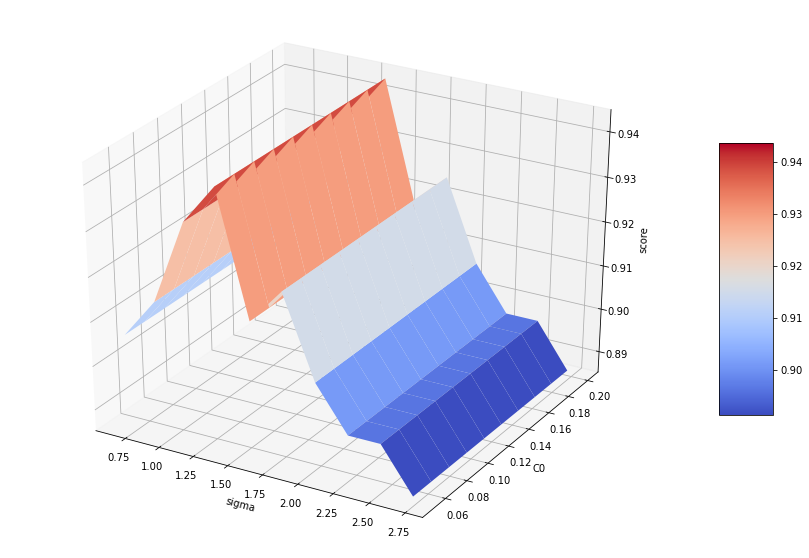

In [139]:
plot_score_surface(sigma_range, C0_range, gs, 'conservative', 'sigma', 'C0')

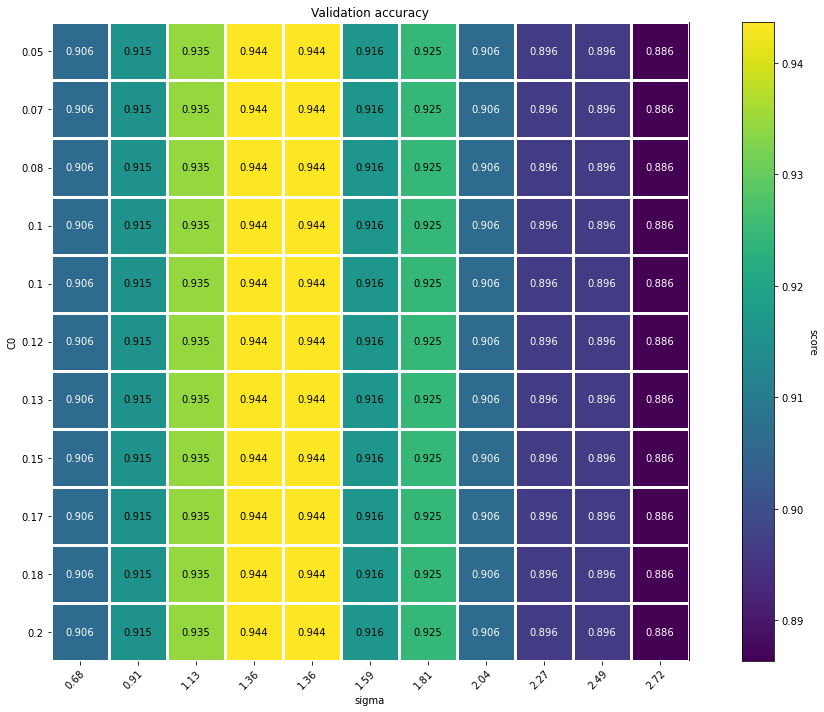

In [140]:
plot_score_heatmap(C0_range, sigma_range, gs, 'conservative', 'sigma', 'C0')

## Iris-versicolor non-conservative metric GridSearch

In [141]:
logging.info('*** Iris-versicolor non-conservative metric GridSearch ***')

In [142]:
C0_range = np.concatenate((np.logspace(-1, 0, 5), []))
C1_range = np.concatenate((np.logspace(-1, 0, 5), [0.468]))
sigma_range = np.concatenate((np.logspace(-1, 1, 5), [1.36]))
scoring = {'non-conservative': make_scorer(non_conservative_score)}
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)  # StratifiedKFold should be default with ClassifierMixin

In [143]:
logging.info('C0_range: ' + str(C0_range))
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))


In [144]:
gs = GridSearchCV(ShadowedSetEstimator(solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='non-conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(),
             param_grid={'C0': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ]),
                         'C1': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ,
       0.468     ]),
                         'sigma': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ,
        1.36      ])},
             refit='non-conservative', return_train_score=True,
             scoring={'non-conservative': make_scorer(non_conservative_score)})

In [145]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                            0.0606595
std_fit_time                                                            0.00190105
mean_score_time                                                          0.0036201
std_score_time                                                         0.000441339
param_C0                                                                         1
param_C1                                                                  0.562341
param_sigma                                                                   1.36
params                           {'C0': 1.0, 'C1': 0.5623413251903491, 'sigma':...
split0_test_non-conservative                                              0.909091
split1_test_non-conservative                                              0.909091
split2_test_non-conservative                                              0.909091
split3_test_non-conservative                                              0.909091
spli

In [146]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.9333333333333333)

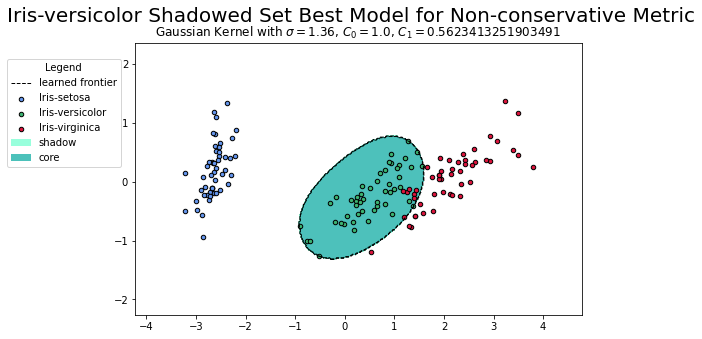

In [147]:
titles = [r'Gaussian Kernel with $\sigma =' + str(gs.best_params_['sigma']) + '$, $C_0 = '
          + str(gs.best_params_['C0']) + '$, $C_1 = ' + str(gs.best_params_['C1']) + '$']

suptitle = 'Iris-versicolor Shadowed Set Best Model for Non-conservative Metric'
contourf_levels = [-2, -1, 0, 1]
contourf_colors = ['white', 'aquamarine', 'lightseagreen', 'red']
contour_levels = [-1, 0]
models = [final_model]
plot_shadowed_set(1, 1, X, iris_labels, labels, label_colors, models, titles, suptitle,
                      contourf_levels, contourf_colors, contour_levels)

## Iris-versicolor non-conservative metric score charts with fixed C1

In [148]:
logging.info('*** Iris-versicolor non-conservative metric score charts with fixed C1 ***')

In [149]:
best_C0 = gs.best_params_['C0']
best_C1 = gs.best_params_['C1']
best_sigma = gs.best_params_['sigma']

In [150]:
logging.info('best_C0: ' + str(best_C0))
logging.info('best_C1: ' + str(best_C1))
logging.info('best_sigma: ' + str(best_sigma))

In [151]:
C0_range = np.sort(np.concatenate((np.linspace(best_C0 / 2, best_C0 * 2, 10), [best_C0])))
sigma_range = np.sort(np.concatenate((np.linspace(best_sigma / 2, best_sigma * 2, 10), [best_sigma])))
scoring = {'non-conservative': make_scorer(non_conservative_score)}
param_grid = {'C0': C0_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [152]:
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [153]:
# Fisso C1 perché ininfluente ai fini della metrica Non-conservative (gli incerti sono classificati come 1)
gs = GridSearchCV(ShadowedSetEstimator(C1=best_C1, solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='non-conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(C1=0.5623413251903491),
             param_grid={'C0': array([0.5       , 0.66666667, 0.83333333, 1.        , 1.        ,
       1.16666667, 1.33333333, 1.5       , 1.66666667, 1.83333333,
       2.        ]),
                         'sigma': array([0.68      , 0.90666667, 1.13333333, 1.36      , 1.36      ,
       1.58666667, 1.81333333, 2.04      , 2.26666667, 2.49333333,
       2.72      ])},
             refit='non-conservative', return_train_score=True,
             scoring={'non-conservative': make_scorer(non_conservative_score)})

In [154]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                     0.0615596
std_fit_time                                     0.00167507
mean_score_time                                  0.00370574
std_score_time                                  0.000584455
param_C0                                                  1
param_sigma                                            1.36
params                           {'C0': 1.0, 'sigma': 1.36}
split0_test_non-conservative                       0.909091
split1_test_non-conservative                       0.909091
split2_test_non-conservative                       0.909091
split3_test_non-conservative                       0.909091
split4_test_non-conservative                              1
split5_test_non-conservative                            0.9
split6_test_non-conservative                              1
split7_test_non-conservative                            0.9
split8_test_non-conservative                              1
split9_test_non-conservative            

In [155]:
pd.DataFrame(gs.cv_results_)[['param_C0', 'param_sigma', 'mean_test_non-conservative']]

param_C0 param_sigma  mean_test_non-conservative
0        0.5        0.68                    0.906364
1        0.5    0.906667                    0.915455
2        0.5     1.13333                    0.934545
3        0.5        1.36                    0.934545
4        0.5        1.36                    0.934545
..       ...         ...                         ...
116        2     1.81333                    0.924545
117        2        2.04                    0.906364
118        2     2.26667                    0.896364
119        2     2.49333                    0.896364
120        2        2.72                    0.886364

[121 rows x 3 columns]

In [156]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.9333333333333333)

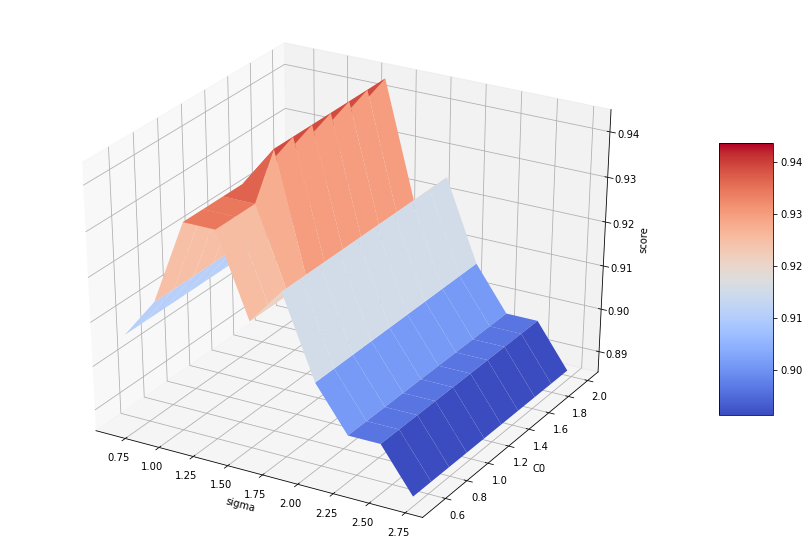

In [157]:
plot_score_surface(sigma_range, C0_range, gs, 'non-conservative', 'sigma', 'C0')

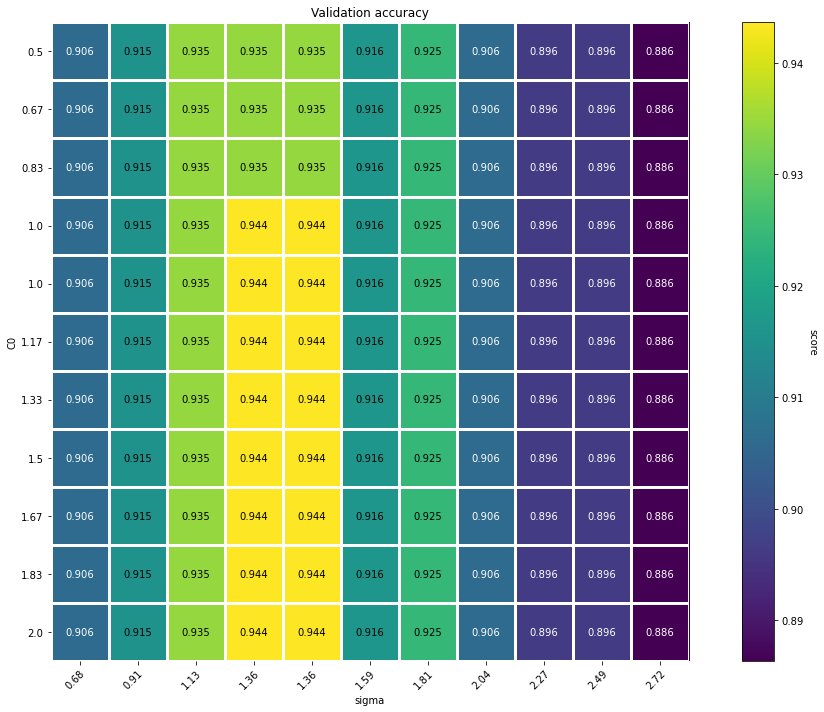

In [158]:
plot_score_heatmap(C0_range, sigma_range, gs, 'non-conservative', 'sigma', 'C0')

## Iris-versicolor non-conservative metric score charts with fixed C0

In [159]:
logging.info('*** Iris-versicolor non-conservative metric score charts with fixed C0 ***')

In [160]:
C1_range = np.sort(np.concatenate((np.linspace(best_C1 / 2, best_C1 * 2, 10), [best_C1])))
sigma_range = np.sort(np.concatenate((np.linspace(best_sigma / 2, best_sigma * 2, 10), [best_sigma])))
scoring = {'non-conservative': make_scorer(non_conservative_score)}
param_grid = {'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [161]:
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [162]:
gs = GridSearchCV(ShadowedSetEstimator(C0=best_C0, solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='non-conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(C0=1.0),
             param_grid={'C1': array([0.28117066, 0.37489422, 0.46861777, 0.56234133, 0.56234133,
       0.65606488, 0.74978843, 0.84351199, 0.93723554, 1.0309591 ,
       1.12468265]),
                         'sigma': array([0.68      , 0.90666667, 1.13333333, 1.36      , 1.36      ,
       1.58666667, 1.81333333, 2.04      , 2.26666667, 2.49333333,
       2.72      ])},
             refit='non-conservative', return_train_score=True,
             scoring={'non-conservative': make_scorer(non_conservative_score)})

In [163]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                     0.0638813
std_fit_time                                                     0.00520496
mean_score_time                                                   0.0038063
std_score_time                                                  0.000292842
param_C1                                                           0.468618
param_sigma                                                            1.36
params                           {'C1': 0.46861777099195756, 'sigma': 1.36}
split0_test_non-conservative                                       0.909091
split1_test_non-conservative                                       0.909091
split2_test_non-conservative                                       0.909091
split3_test_non-conservative                                       0.909091
split4_test_non-conservative                                              1
split5_test_non-conservative                                            0.9
split6_test_

In [164]:
pd.DataFrame(gs.cv_results_)[['param_C1', 'param_sigma', 'mean_test_non-conservative']]

param_C1 param_sigma  mean_test_non-conservative
0    0.281171        0.68                    0.906364
1    0.281171    0.906667                    0.915455
2    0.281171     1.13333                    0.925455
3    0.281171        1.36                    0.925455
4    0.281171        1.36                    0.925455
..        ...         ...                         ...
116   1.12468     1.81333                    0.924545
117   1.12468        2.04                    0.906364
118   1.12468     2.26667                    0.896364
119   1.12468     2.49333                    0.896364
120   1.12468        2.72                    0.886364

[121 rows x 3 columns]

In [165]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.9333333333333333, 0.9333333333333333)

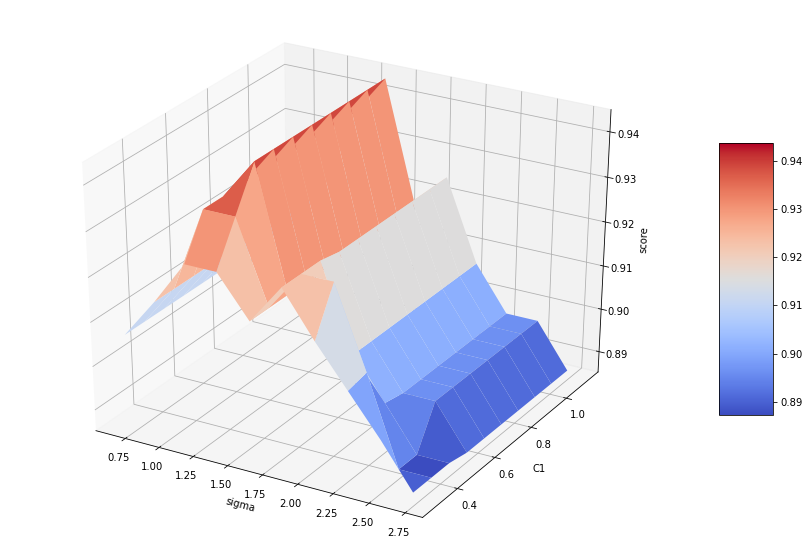

In [166]:
plot_score_surface(sigma_range, C1_range, gs, 'non-conservative', 'sigma', 'C1')

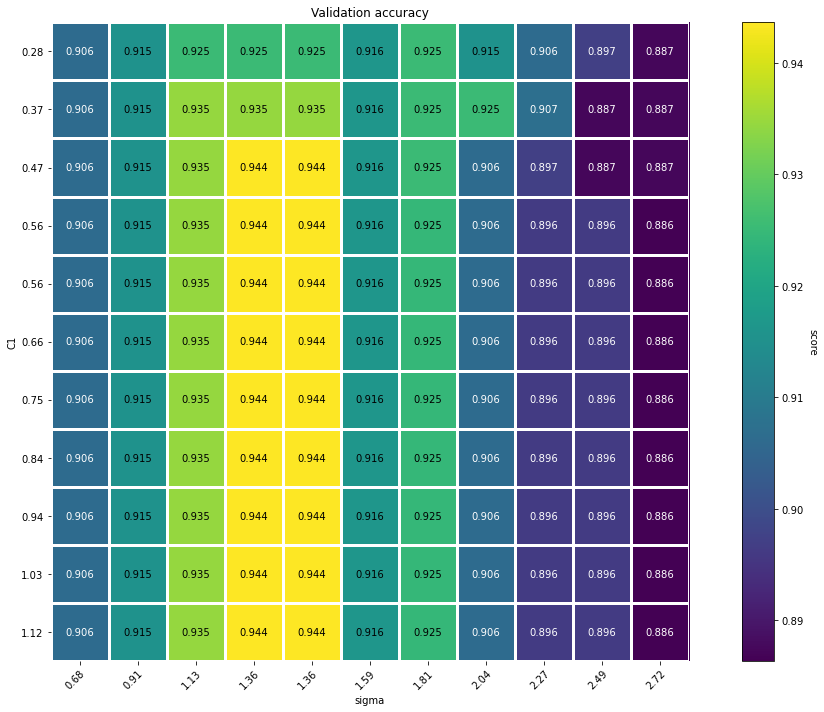

In [167]:
plot_score_heatmap(C1_range, sigma_range,  gs, 'non-conservative', 'sigma', 'C1')

## Iris-setosa conservative metric GridSearch

In [168]:
logging.info('*** Iris-setosa conservative metric GridSearch ***')

In [169]:
X, y, iris_labels = load_iris(d=2, target='Iris-setosa')
X_train, y_train, iris_train_labels = [], [], []
X_test, y_test, iris_test_labels = [], [], []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

logging.info('Splitting in training and test sets with ' + str(sss))

for train_index, test_index in sss.split(X, iris_labels):
    X_train = X[train_index]
    y_train = y[train_index]
    iris_train_labels = iris_labels[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    iris_test_labels = iris_labels[test_index]

pd.Series(iris_train_labels).value_counts(), pd.Series(iris_test_labels).value_counts()

(Iris-setosa        35
 Iris-versicolor    35
 Iris-virginica     35
 dtype: int64,
 Iris-setosa        15
 Iris-versicolor    15
 Iris-virginica     15
 dtype: int64)

In [170]:
logging.info('X_train: ' + str(X_train))
logging.info('y_train: ' + str(y_train))
logging.info('iris_train_labels: ' + str(iris_train_labels))
logging.info('X_test: ' + str(X_test))
logging.info('y_test: ' + str(y_test))
logging.info('iris_test_labels: ' + str(iris_test_labels))

In [171]:
C0_range = [0.1, 0.3, 0.7, 1, 5]
C1_range = [0.1, 0.3, 0.5, 0.7, 1]
sigma_range = [.1, .5, 1, 1.32, 1.5, 2]
scoring = {'conservative': make_scorer(conservative_score)}
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [172]:
logging.info('C0_range: ' + str(C0_range))
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [173]:
gs = GridSearchCV(ShadowedSetEstimator(solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(),
             param_grid={'C0': [0.1, 0.3, 0.7, 1, 5],
                         'C1': [0.1, 0.3, 0.5, 0.7, 1],
                         'sigma': [0.1, 0.5, 1, 1.32, 1.5, 2]},
             refit='conservative', return_train_score=True,
             scoring={'conservative': make_scorer(conservative_score)})

In [174]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                            0.0606673
std_fit_time                                            0.00252143
mean_score_time                                         0.00366082
std_score_time                                         0.000392785
param_C0                                                       0.1
param_C1                                                       0.7
param_sigma                                                   1.32
params                       {'C0': 0.1, 'C1': 0.7, 'sigma': 1.32}
split0_test_conservative                                         1
split1_test_conservative                                         1
split2_test_conservative                                  0.818182
split3_test_conservative                                         1
split4_test_conservative                                         1
split5_test_conservative                                         1
split6_test_conservative                                      

In [175]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(1.0, 0.9333333333333333)

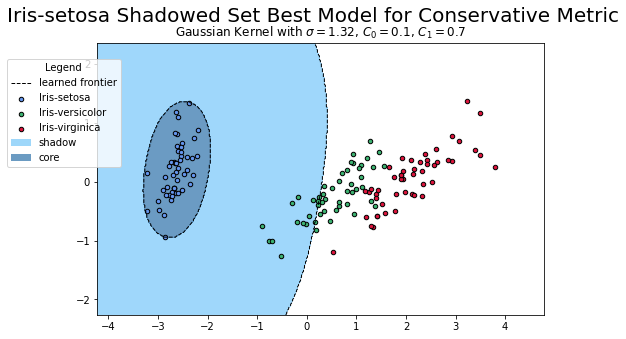

In [176]:
titles = [r'Gaussian Kernel with $\sigma =' + str(gs.best_params_['sigma']) + '$, $C_0 = '
          + str(gs.best_params_['C0']) + '$, $C_1 = ' + str(gs.best_params_['C1']) + '$']

suptitle = 'Iris-setosa Shadowed Set Best Model for Conservative Metric'
contourf_levels = [-2, -1, 0, 1]
contourf_colors = ['white', 'lightskyblue', 'steelblue', 'red']
contour_levels = [-1, 0]
models = [final_model]
plot_shadowed_set(1, 1, X, iris_labels, labels, label_colors, models, titles, suptitle,
                      contourf_levels, contourf_colors, contour_levels)

## Iris-setosa conservative metric score charts

In [177]:
logging.info('*** Iris-setosa conservative metric score charts ***')

In [178]:
C1_range = np.linspace(0.1, 2, 10)
sigma_range = np.linspace(0.1, 2, 10)
scoring = {'conservative': make_scorer(conservative_score)}
param_grid = {'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [179]:
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [180]:
# Fisso C0 perché ininfluente ai fini della metrica Conservative (gli incerti sono classificati come -1)
gs = GridSearchCV(ShadowedSetEstimator(C0=gs.best_params_['C0'], solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(),
             param_grid={'C1': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'sigma': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ])},
             refit='conservative', return_train_score=True,
             scoring={'conservative': make_scorer(conservative_score)})

In [181]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                        0.0605772
std_fit_time                                                        0.00139387
mean_score_time                                                     0.00379901
std_score_time                                                      0.00029076
param_C1                                                              0.522222
param_sigma                                                            1.36667
params                       {'C1': 0.5222222222222223, 'sigma': 1.36666666...
split0_test_conservative                                                     1
split1_test_conservative                                                     1
split2_test_conservative                                              0.818182
split3_test_conservative                                                     1
split4_test_conservative                                                     1
split5_test_conservative                            

In [182]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(1.0, 0.9333333333333333)

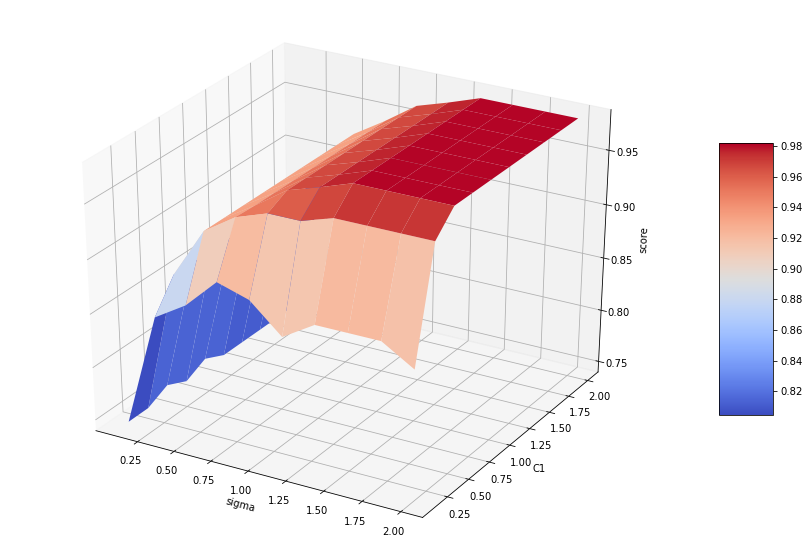

In [183]:
plot_score_surface(sigma_range, C1_range, gs, 'conservative', 'sigma', 'C1')

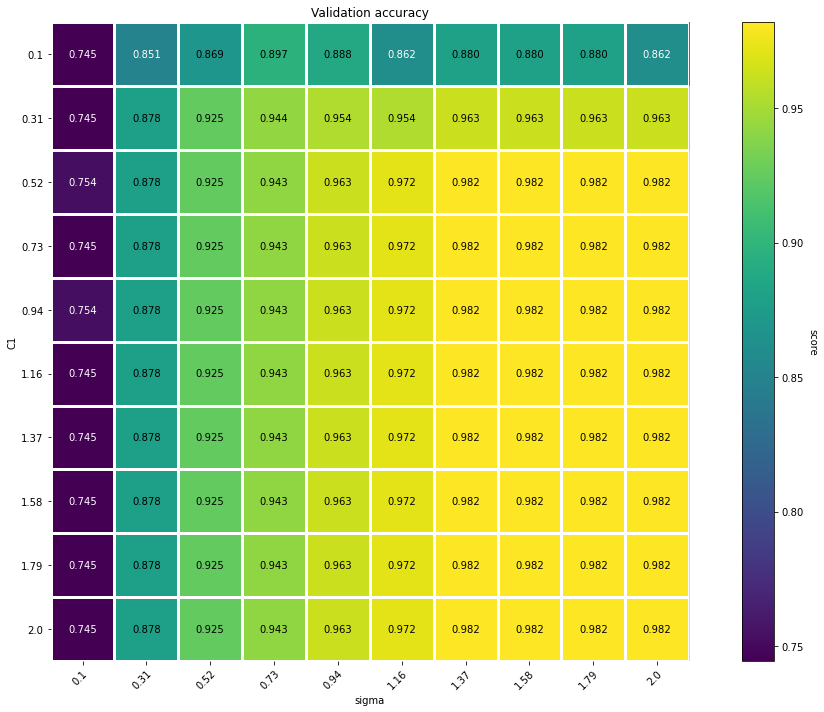

In [184]:
plot_score_heatmap(sigma_range, C1_range, gs, 'conservative', 'sigma', 'C1')

## Iris-setosa non-conservative metric GridSearch

In [185]:
logging.info('*** Iris-setosa non-conservative metric GridSearch ***')

In [186]:
C0_range = [0.1, 0.3, 0.7, 1, 5]
C1_range = [0.1, 0.3, 0.7, 1]
sigma_range = [ .1, .3, .5, 1, 1.5, 2]
scoring = {'non-conservative': make_scorer(non_conservative_score)}
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)  # StratifiedKFold should be default with ClassifierMixin

In [187]:
logging.info('C0_range: ' + str(C0_range))
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [188]:
gs = GridSearchCV(ShadowedSetEstimator(solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='non-conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(),
             param_grid={'C0': [0.1, 0.3, 0.7, 1, 5], 'C1': [0.1, 0.3, 0.7, 1],
                         'sigma': [0.1, 0.3, 0.5, 1, 1.5, 2]},
             refit='non-conservative', return_train_score=True,
             scoring={'non-conservative': make_scorer(non_conservative_score)})

In [189]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                                0.070548
std_fit_time                                                0.0093012
mean_score_time                                            0.00351596
std_score_time                                            0.000480701
param_C0                                                          0.1
param_C1                                                          0.1
param_sigma                                                       0.1
params                           {'C0': 0.1, 'C1': 0.1, 'sigma': 0.1}
split0_test_non-conservative                                        1
split1_test_non-conservative                                        1
split2_test_non-conservative                                        1
split3_test_non-conservative                                        1
split4_test_non-conservative                                        1
split5_test_non-conservative                                        1
split6_test_non-cons

In [190]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.6888888888888889, 1.0)

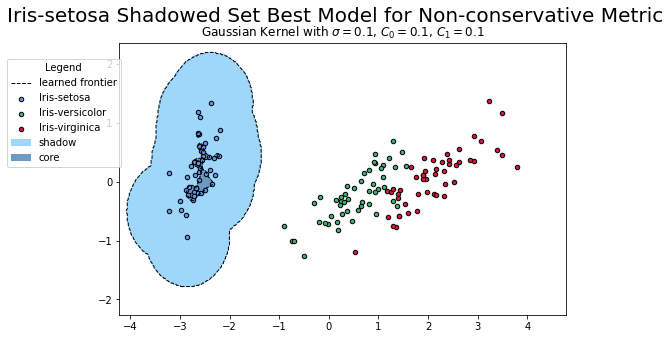

In [191]:
titles = [r'Gaussian Kernel with $\sigma =' + str(gs.best_params_['sigma']) + '$, $C_0 = '
          + str(gs.best_params_['C0']) + '$, $C_1 = ' + str(gs.best_params_['C1']) + '$']

suptitle = 'Iris-setosa Shadowed Set Best Model for Non-conservative Metric'
contourf_levels = [-2, -1, 0, 1]
contourf_colors = ['white', 'lightskyblue', 'steelblue', 'red']
contour_levels = [-1, 0]
models = [final_model]
plot_shadowed_set(1, 1, X, iris_labels, labels, label_colors, models, titles, suptitle,
                      contourf_levels, contourf_colors, contour_levels)

## Iris-setosa non-conservative metric score charts

In [192]:
logging.info('*** Iris-setosa non-conservative metric score charts ***')

In [193]:
C0_range = np.linspace(0.1, 2, 10)
sigma_range = np.linspace(0.1, 2, 10)
scoring = {'non-conservative': make_scorer(non_conservative_score)}
param_grid = {'C0': C0_range, 'sigma': sigma_range}
cv = StratifiedKFold(10, random_state=42, shuffle=True)

In [194]:
logging.info('C1_range: ' + str(C1_range))
logging.info('sigma_range: ' + str(sigma_range))
logging.info('scoring: ' + str(scoring))
logging.info('param_grid: ' + str(param_grid))
logging.info('cv: ' + str(cv))

In [195]:
# Fisso C1 perché ininfluente ai fini della metrica Non-conservative (gli incerti sono classificati come 1)
gs = GridSearchCV(ShadowedSetEstimator(C1=gs.best_params_['C1'], solver='tensorflow-two-phases'),
                  cv=cv,
                  param_grid=param_grid,
                  scoring=scoring, refit='non-conservative', return_train_score=True)

logging.info('GridSearchCV: ' + str(gs))

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ShadowedSetEstimator(C1=0.1),
             param_grid={'C0': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'sigma': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ])},
             refit='non-conservative', return_train_score=True,
             scoring={'non-conservative': make_scorer(non_conservative_score)})

In [196]:
logging.info('cv_results of best_index: ' + str(pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]))
pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

mean_fit_time                                    0.0686707
std_fit_time                                    0.00163004
mean_score_time                                 0.00370052
std_score_time                                 0.000386731
param_C0                                               0.1
param_sigma                                            0.1
params                           {'C0': 0.1, 'sigma': 0.1}
split0_test_non-conservative                             1
split1_test_non-conservative                             1
split2_test_non-conservative                             1
split3_test_non-conservative                             1
split4_test_non-conservative                             1
split5_test_non-conservative                             1
split6_test_non-conservative                             1
split7_test_non-conservative                             1
split8_test_non-conservative                             1
split9_test_non-conservative                            

In [197]:
final_model = gs.best_estimator_

logging.info('best_estimator: ' + str(gs.best_estimator_))
logging.info('conservative score: ' + str(conservative_score(y_test, final_model.predict(X_test))))
logging.info('non-conservative score: ' + str(non_conservative_score(y_test, final_model.predict(X_test))))

conservative_score(y_test, final_model.predict(X_test)), non_conservative_score(y_test, final_model.predict(X_test))

(0.6888888888888889, 1.0)

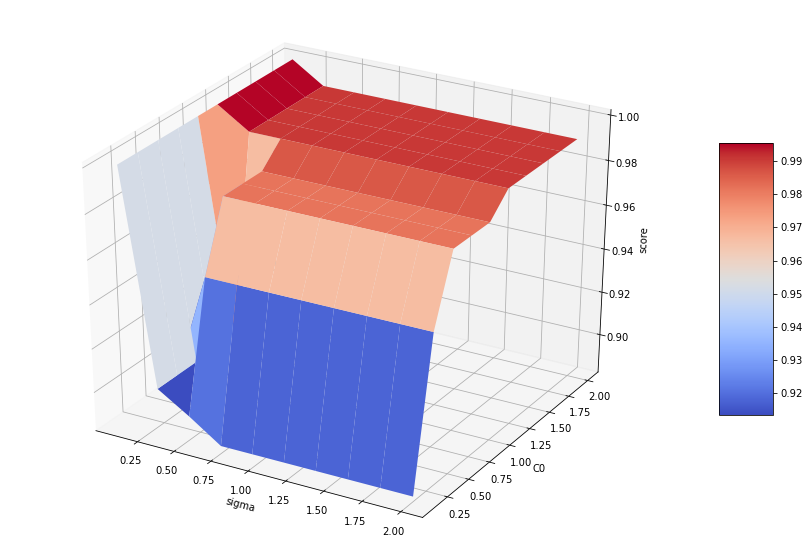

In [198]:
plot_score_surface(sigma_range, C0_range, gs, 'non-conservative', 'sigma', 'C0')

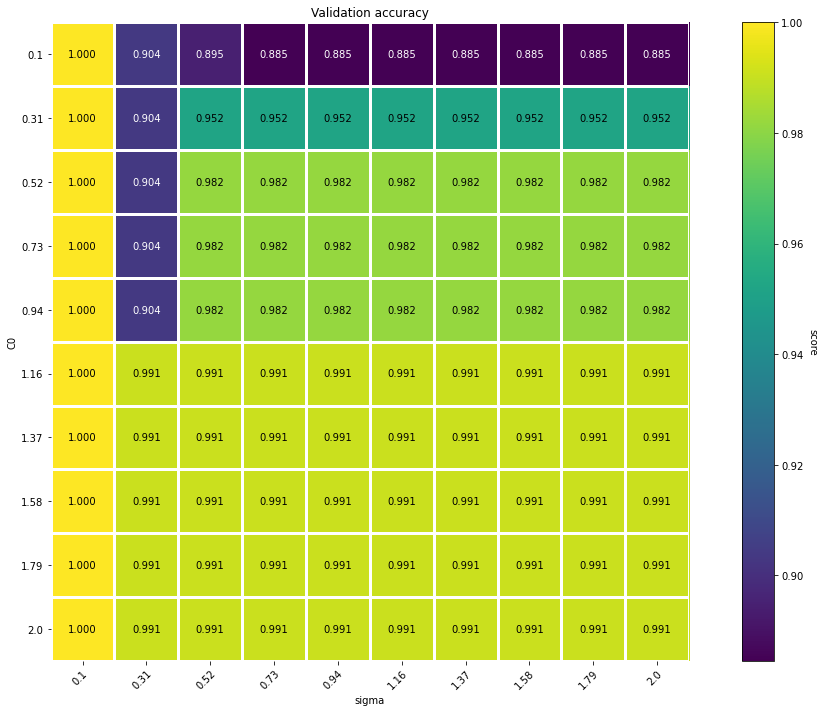

In [199]:
plot_score_heatmap(sigma_range, C0_range, gs, 'non-conservative', 'sigma', 'C0')

In [ ]:
log_last_execution('Finished Grid Search for TensorFlow Two Phases Models on Iris dataset')